## Importation des bibliothèques nécessaires

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.image as img
import datetime
import os
import random

from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras import datasets, layers, models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau


print("Libs imported")

Libs imported


In [ ]:
 print(tf.__version__)

2.5.0


In [ ]:

print(keras.__version__)

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importation de la DataFrame : 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

In [ ]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


Data Préparation : 


In [ ]:
classes = ['Angry' , 'Disgust' , 'Fear' , 'Happy' , 'Sad' , 'Surprise' , 'Neutral'] 

In [ ]:
df_emotion = df.copy()

df_emotion["emotion"].replace({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"} , inplace = True)
df_emotion

,emotion,pixels,Usage
0,Angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,Angry,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,Fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,Sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,Neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,Neutral,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,Happy,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,Angry,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,Happy,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


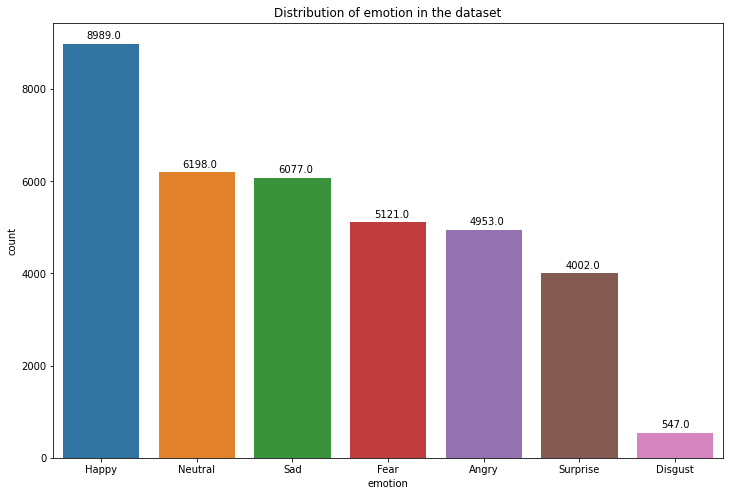

In [ ]:
plt.figure(figsize=(12,8))
 
ax = sns.countplot(x="emotion",  data=df_emotion ,   order = df_emotion['emotion'].value_counts().index )

plt.title('Distribution of emotion in the dataset')
plt.xlabel('emotion')
plt.ylabel('count')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+100))

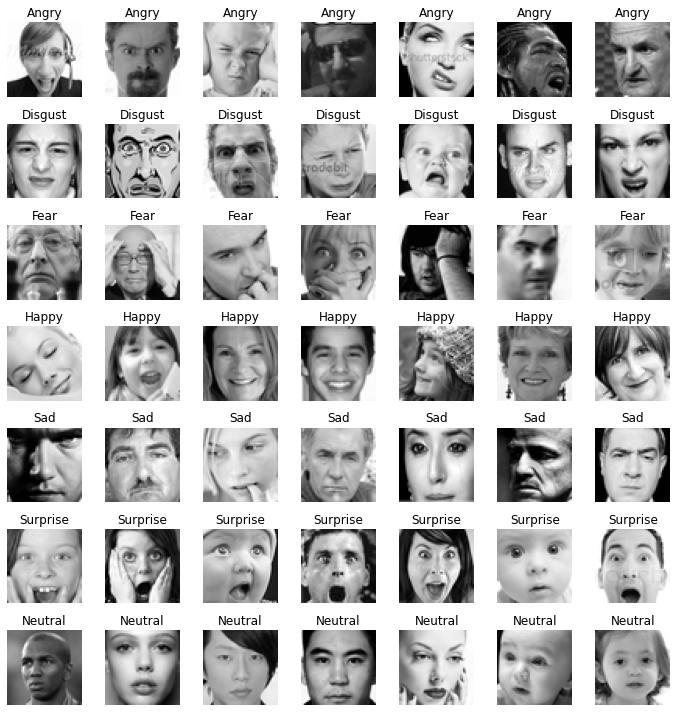

In [ ]:
fig = plt.figure(1, (10, 10))

k=0
for label in classes :
    for j in range(7):
        f , g = random.randint(0,500) , random.randint(0,10)
        px = df_emotion[df_emotion.emotion==label].pixels.iloc[f+g]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1

        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_title(label)
        plt.axis('off')        
        plt.tight_layout()

In [ ]:
    df.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [ ]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

splitting de la base de donnée : 

In [ ]:
df_train_plot = df_emotion[df_emotion["Usage"] == "Training"].copy()
df_validation_plot  =  df_emotion[df_emotion['Usage'] == 'PublicTest'].copy()
df_test_plot =  df_emotion[df_emotion['Usage'] == 'PrivateTest'].copy()

print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(df_train_plot.shape, df_validation_plot.shape, df_test_plot.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:

df_train_plot

,emotion,pixels,Usage
0,Angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,Angry,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,Fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,Sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,Neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,Fear,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,Angry,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,Sad,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,Angry,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


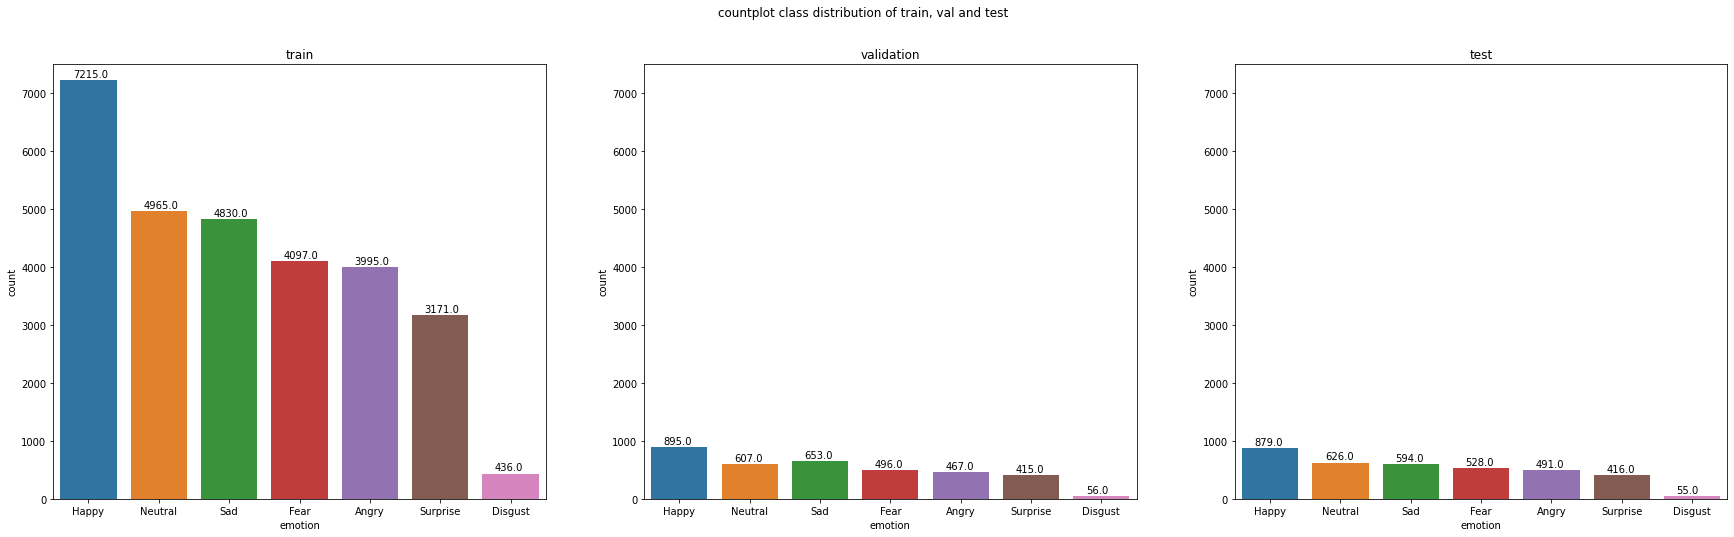

In [ ]:
l=['train' , 'validation' , 'test']
df_list = [df_train_plot , df_validation_plot , df_test_plot]

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharex=True)
fig.suptitle('countplot class distribution of train, val and test')

for i in range(3):
    axes[i].set(ylim=(0, 7500))
    sns.countplot(ax=axes[i] , x="emotion",  data=df_list[i] , order = df_train_plot['emotion'].value_counts().index )
    axes[i].set_title(l[i])
    for p in axes[i].patches:
        axes[i].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.18, p.get_height()+50))

In [ ]:
df_train = df[df_emotion["Usage"] == "Training"].copy()
df_validation  =  df[df_emotion['Usage'] == 'PublicTest'].copy()
df_test =  df[df_emotion['Usage'] == 'PrivateTest'].copy()

In [ ]:
raw_X_train = df_train["pixels"].to_list()
raw_y_train = df_train["emotion"].to_list()

In [ ]:
len(raw_X_train)

28709

In [ ]:
len(raw_X_train[0].split())**0.5 #nombre de pixels de chaque coté pour chaque image

48.0

In [ ]:
len(raw_y_train)

28709

In [ ]:
df_test = df[df["Usage"] == "PublicTest"]

In [ ]:
raw_X_test = df_test["pixels"].to_list()
raw_y_test = df_test["emotion"].to_list()

In [ ]:
len(raw_X_test)

3589

In [ ]:
len(raw_y_test)

3589

In [ ]:
raw_X_val = df_validation["pixels"].to_list()
raw_y_val = df_validation["emotion"].to_list()

In [ ]:
len(raw_X_val)

3589

In [ ]:
len(raw_y_val)

3589

In [ ]:
X_train = []
y_train = np.array(raw_y_train)

for e in raw_X_train : 
    X_train.append(list(map(int, e.split())))

X_train = np.array(X_train).reshape((len(raw_X_train) , 48 , 48 , 1))

In [ ]:
X_train.shape

(28709, 48, 48, 1)

In [ ]:
X_test = []
y_test = np.array(raw_y_test)

for e in raw_X_test : 
        X_test.append(list(map(int, e.split())))

X_test = np.array(X_test).reshape((len(raw_X_test) , 48 , 48 , 1))
    

In [ ]:
X_test.shape

(3589, 48, 48, 1)

In [ ]:
X_val = []
y_val = np.array(raw_y_val)

for e in raw_X_val : 
        X_val.append(list(map(int, e.split())))

X_val = np.array(X_val).reshape((len(raw_X_val) , 48 , 48 , 1))
    

In [ ]:
X_val.shape

(3589, 48, 48, 1)

Normalisation des données : 

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

**Data augmentation**:

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                                rotation_range=45, 
                                featurewise_center=False,
                                featurewise_std_normalization=False,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=.1,
                                horizontal_flip=True,
                                fill_mode='reflect')

In [ ]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

Création du modèle :

In [ ]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    # #Compliling the model
    # model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
    #               loss='categorical_crossentropy', 
    #               metrics=['accuracy'])
    return model

model = get_model (input_size=(48, 48,1), classes = 7)
xlen = len(X_train)
model.build(input_shape=(xlen,48, 48,1))

### 

model.compile(
                        #   optimizer = tf.keras.optimizers.RMSprop(learning_rate = .0001),
                          optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-5),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

batch_size = 64
num_epochs = 100

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 256)      

In [ ]:
history = model.fit(data_generator.flow(X_train, y_train, batch_size),
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=num_epochs,
                                verbose=1, 
                                #callbacks = [es],
                                validation_data=(X_val, y_val))

Epoch 1/100
448/448 [==============================] - 26s 54ms/step - loss: 12.4020 - accuracy: 0.2234 - val_loss: 12.6496 - val_accuracy: 0.1700
Epoch 2/100
448/448 [==============================] - 23s 51ms/step - loss: 9.9691 - accuracy: 0.2453 - val_loss: 9.6924 - val_accuracy: 0.2530
Epoch 3/100
448/448 [==============================] - 24s 53ms/step - loss: 7.6898 - accuracy: 0.2520 - val_loss: 7.4881 - val_accuracy: 0.2533
Epoch 4/100
448/448 [==============================] - 24s 53ms/step - loss: 5.7914 - accuracy: 0.2734 - val_loss: 5.1853 - val_accuracy: 0.3126
Epoch 5/100
448/448 [==============================] - 24s 53ms/step - loss: 4.3815 - accuracy: 0.2869 - val_loss: 6.5930 - val_accuracy: 0.2775
Epoch 6/100
448/448 [==============================] - 23s 52ms/step - loss: 3.3949 - accuracy: 0.3178 - val_loss: 3.1309 - val_accuracy: 0.3809
Epoch 7/100
448/448 [==============================] - 24s 53ms/step - loss: 2.7335 - accuracy: 0.3489 - val_loss: 2.3771 - val_

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

113/113 [==============================] - 1s 9ms/step - loss: 1.1414 - accuracy: 0.6406
accuracy: 64.06%


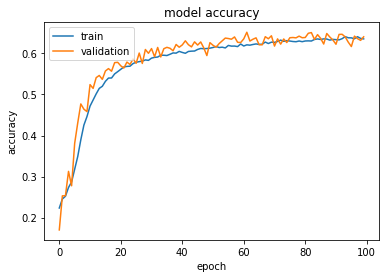

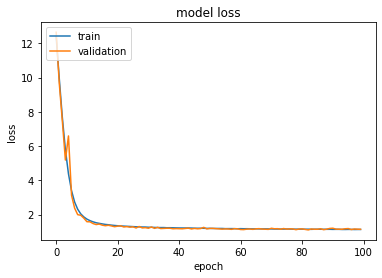

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

saving The model into hdf5 file :

In [ ]:
model.save("my_model.hdf5")

testing du modèle sur des images externe : 

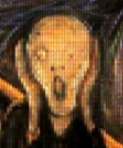

In [ ]:
from PIL import Image
im = Image.open('fear.png') #importer une image à google colab et le renommer à "fear.png"
img = im
im = im.resize((48,48)).convert('L')

numpydata = np.asarray(im)
#print(numpydata.shape)
img


In [ ]:
classes[np.argmax((model.predict(numpydata.reshape((1,48,48,1))))[0])]

'Fear'

In [ ]:
y_pred = np.array([np.argmax(e) for e in model.predict(X_test)])

In [ ]:
print(y_pred[:200])

[0 3 0 6 3 3 4 6 4 2 3 0 4 2 6 5 5 5 5 3 6 5 6 4 0 6 4 4 0 5 3 6 3 6 6 4 4
 5 4 3 0 4 6 6 6 0 5 3 5 6 6 3 5 2 4 3 2 4 5 3 6 3 4 5 2 3 5 6 2 3 6 5 6 3
 3 6 5 6 4 4 0 0 0 3 5 1 3 3 3 3 4 0 3 6 0 0 5 3 3 0 3 6 4 3 5 3 6 6 6 3 3
 0 0 4 3 2 3 6 2 6 5 3 0 2 4 3 3 6 5 5 2 6 2 6 5 5 5 3 6 6 0 3 0 4 4 6 3 3
 3 2 6 0 5 3 4 5 4 5 2 3 0 3 3 3 6 6 6 4 5 3 6 4 5 6 0 6 0 0 4 5 4 3 2 3 3
 4 2 3 3 3 3 6 4 5 3 4 5 6 0 4]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


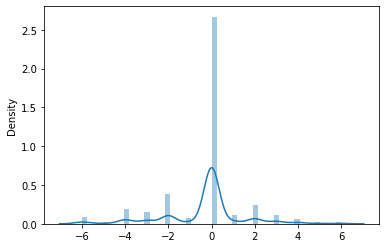

In [ ]:
sns.distplot((y_test - y_pred) )

calcul direct de l'accuracy du modèle à partir de y_test

In [ ]:
s=0
for i in range(len(y_test)):
    if y_pred[i] == y_test[i]:
        s += 1
print(s/len(y_test))

0.6405684034550014


# Interface Graphique 

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def snap(inp):
    inpt = inp.reshape((-1, 48, 48, 1))
    out = classes[np.argmax((model.predict(inpt))[0])]
    return out
gr.Interface(fn=snap , inputs = gr.inputs.Image(shape=(48, 48)) , outputs="label").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://34395.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7867/',
 'https://34395.gradio.app')